In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.datasets import fetch_openml, load_digits
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import time
from random import shuffle
from math import ceil
import warnings
warnings.filterwarnings('ignore')

# Data Collection

In [2]:
digits=load_digits()
digitsX = digits.data
targets = digits.target
digitsy = np.zeros((digitsX.shape[0], 10))
for i in range(digitsX.shape[0]):
    digitsy[i][targets[i]] = 1
digitsX.shape

(1797, 64)

In [3]:
#3 classes
penguins = fetch_openml(name='penguins')

#load data and targets
data = penguins.data
targets = penguins.target

# create dataframe for penguins by concatenating data and targets
data_df = pd.DataFrame(data, columns=penguins.feature_names)
targets_df = pd.DataFrame(targets, columns=penguins.target_names)
penguins_df = pd.concat([data_df, targets_df],axis='columns')

# drop instances with NaN values
penguins_df.dropna(inplace=True, axis=0)

#Seperate features and targets
penguinsX = penguins_df[penguins.feature_names].to_numpy()
penguinsy = pd.get_dummies(penguins_df[penguins.target_names]).to_numpy()

penguinsX.shape

(334, 6)

In [4]:
#3 classes
dna = fetch_openml(name='dna', version = 1)

data = dna.data
targets = dna.target

data_df = pd.DataFrame(data, columns=dna.feature_names)
targets_df = pd.DataFrame(targets, columns=dna.target_names)
dna_df = pd.concat([data_df, targets_df],axis='columns')

dna_df.dropna(inplace=True, axis=0)

dnaX = dna_df[dna.feature_names].to_numpy()
dnay = pd.get_dummies(dna_df[dna.target_names]).to_numpy()

dnaX.shape

(3186, 180)

# Classifier

In [5]:
# Gradient Optimizer

softmax = lambda z: np.exp(z - z.max(axis=1, keepdims = True)) / np.exp(z - z.max(axis=1, keepdims = True)).sum(axis=1)[:,None]

class Optimizer:
    
    def __init__(self, batch_size=10, learning_rate=0.1, momentum=0, max_iters=1e4, epsilon=1e-8, record_history=False, l1=0, l2=0):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.max_iters = max_iters
        self.epsilon = epsilon
        self.record_history = record_history
        self.l1 = l1
        self.l2 = l2
        if record_history:
            self.w_history = []                 #to store the weight history for visualization
            
    def optimize(self, x, y, x_test, y_test):
        N,D = x.shape
        w = np.zeros((y.shape[1],D))
        grad = np.inf
        t = 0
        grads_prev = []
        accuracies_prev = []
        w_prev = []
        while np.linalg.norm(grad) > self.epsilon and t < self.max_iters:
            grad_prev = grad
            grad = self.gradient(x, y, w) + self.l1 * np.column_stack([np.sign(w[:,1:]),np.zeros(w.shape[0])]) + self.l2 * np.column_stack([w[:,1:],np.zeros(w.shape[0])])  # compute the gradient, apply l1 or l2 regularization if specified
            if t > 0:
                grad = self.momentum * grad_prev + (1 - self.momentum) * grad
            if self.learning_rate == 0:           # special case, use decreasing learning rate
                w = w - (1 / (t + 1)) * grad      # weight update step using 1 / (t+1)
            else:
                w = w - self.learning_rate * grad         # weight update step using specified learning rate
            if self.record_history:
                self.w_history.append(w)
            t += 1
            grads_prev.append(grad)
            accuracies_prev.append(accuracy_score(y_test.argmax(axis=1), softmax(np.column_stack([x_test,np.ones(x_test.shape[0])])@w.T).argmax(axis=1)))
            w_prev.append(w)
            if len(accuracies_prev) > 21:
                if accuracies_prev[-1] <= max(accuracies_prev[-21:-1]):
                    i = accuracies_prev.index(max(accuracies_prev))
                    return [w_prev[i], t, np.linalg.norm(grads_prev[i])]
        return [w, t, np.linalg.norm(grad)]
    
    def gradient(self, x, y, w):
        index = np.random.choice(x.shape[0], self.batch_size, replace=False) # choose a minibatch based on size
        x_batch = x[index]
        y_batch = y[index]
        z = softmax(x_batch@w.T) - y_batch
        return z.T@x_batch
        

In [6]:
# Cost Function

def cost_fn(x, y, w):                                                   
    z = x@w.T
    J = -((y * z).sum(axis=1) - (z.max(axis=1) + np.log(np.exp(z - z.max(axis=1, keepdims=True)).sum(axis=1)))).mean()
    return J

In [7]:
# Softmax Classifier

class softmax_classifier:
    def __init__(self, verbose=False):
        self.verbose = verbose
    
    def fit(self, x, y, x_test, y_test, optimizer):
        if x.ndim == 1:
            x = x[:, None]
        N = x.shape[0]
        x = np.column_stack([x,np.ones(N)])
        results = optimizer.optimize(x, y, x_test, y_test)
        self.w = results[0]
        
        if self.verbose:
            print(f'terminated after {results[1]} iterations, with norm of the gradient equal to {results[2]}')
            print(f'the weight found: {self.w}')
        return self
    
    def predict(self, x):
        if x.ndim == 1:
            x = x[:, None]
        Nt = x.shape[0]
        x = np.column_stack([x,np.ones(Nt)])
        z = softmax(x@self.w.T)
        yh = z.argmax(axis=1)           #predict output
        return yh

# Hyperparameter Optimization

In [8]:
def get_softmax_score(X_train, X_test, y_train, y_test, optimizer):
    start_time = time.time()
    sf= softmax_classifier().fit(X_train, y_train, X_test, y_test, optimizer)
    elapsed_time = time.time() - start_time
    train_predictions = sf.predict(X_train)
    val_predictions = sf.predict(X_test)
    return (accuracy_score(y_train.argmax(axis=1), train_predictions), accuracy_score(y_test.argmax(axis=1), val_predictions), elapsed_time)


In [9]:
def softmax_k_fold(X, y, optimizer, k=5):
    train_scores=[]
    val_scores=[]
    runtimes = []
    indeces = [x for x in range(len(X))]
    shuffle(indeces)
    folds = [indeces[i:i + ceil(len(X) * 0.2)] for i in range(0, len(X), ceil(len(X) * 0.2))]
    for i in range(5):
        train_indeces = []
        for j in range(4):
            train_indeces = train_indeces + folds[(i + j) % 5]
        test_indeces = folds[(i + 4) % 5]
        X_train, X_test, y_train, y_test = X[train_indeces], X[test_indeces], y[train_indeces], y[test_indeces] 
        scores = get_softmax_score(X_train, X_test, y_train, y_test, optimizer)
        train_scores.append(scores[0])
        val_scores.append(scores[1])
        runtimes.append(scores[2])
    return (np.average(np.array(train_scores)), np.average(np.array(val_scores)), np.average(np.array(runtimes)))

In [10]:
b_sizes = range(1, 200, 20)
lrs = [x / 10.0 for x in range(11)]
betas = [x / 10.0 for x in range(11)]
l1s = [x / 10.0 for x in range(1, 23, 2)]
l2s = [x / 10.0 for x in range(1, 23, 2)]

def GridSearch(X,y,param,_bs=50,_lr=0,_beta=0.9):
    train_scores = []
    val_scores = []
    runtimes = []
    train = None
    test = None
    
    if param == 'Batch Size':
        for bs in b_sizes:
            optimizer = Optimizer(batch_size=bs, learning_rate = _lr, momentum = _beta)
            scores = softmax_k_fold(X, y, optimizer, k=5)
            train_scores.append(scores[0])
            val_scores.append(scores[1])
            runtimes.append(scores[2])
        
        #create subplots for graphs
        fig, axs = plt.subplots(ncols=2, figsize=(10,3))
        plt.subplots_adjust(wspace=0.3, hspace=0.5)
        for ax in axs.flat:
            ax.set_xlabel(param, fontsize = 10)
        
        axs[0].set_title("Effect of " + param + " on Accuracy", fontsize = 12)
        axs[1].set_title("Effect of " + param + " on Runtime", fontsize = 12)
        train = axs[0].scatter(b_sizes, train_scores, c='red', label="train")
        test = axs[0].scatter(b_sizes, val_scores, c='blue', label="test")
        axs[0].set(ylabel="Accuracy")
        axs[0].legend(handles=[train,test])
        axs[1].scatter(b_sizes, runtimes, c='purple')
        axs[1].set(ylabel="Runtime (seconds)")
        print ()
        
        
        
#         plt.subplot(1,2,1)
#         train = plt.scatter(b_sizes, train_scores, c='red', label="train")
#         test = plt.scatter(b_sizes, val_scores, c='blue', label="test")
#         plt.legend(handles=[train,test])
#         plt.xlabel(param)
#         plt.ylabel("Accuracy")
#         plt.title("Effect of " + param + " on Accuracy")
#         plt.tight_layout()

#         plt.subplot(1,2,2)
#         plt.scatter(b_sizes, runtimes, c='purple')
#         plt.xlabel(param)
#         plt.ylabel("Runtime (seconds)")
#         plt.title("Effect of " + param + " on Runtime")
#         plt.tight_layout()
        
    if param == 'Learning Rate':
        for lr in lrs:
            optimizer = Optimizer(batch_size=_bs, learning_rate = lr, momentum = _beta)
            scores = softmax_k_fold(X, y, optimizer, k=5)
            train_scores.append(scores[0])
            val_scores.append(scores[1])
            runtimes.append(scores[2])
            
        #create subplots for graphs
        fig, axs = plt.subplots(ncols=2, figsize=(10,3))
        plt.subplots_adjust(wspace=0.3, hspace=0.5)
        for ax in axs.flat:
            ax.set_xlabel(param, fontsize = 10)
        
        axs[0].set_title("Effect of " + param + " on Accuracy", fontsize = 12)
        axs[1].set_title("Effect of " + param + " on Runtime", fontsize = 12)
        train = axs[0].scatter(lrs, train_scores, c='red', label="train")
        test = axs[0].scatter(lrs, val_scores, c='blue', label="test")
        axs[0].set(ylabel="Accuracy")
        axs[0].legend(handles=[train,test])
        axs[1].scatter(lrs, runtimes, c='purple')
        axs[1].set(ylabel="Runtime (seconds)")
        print ()
        
#         ##
#         plt.subplot(1,2,1)
#         train = plt.scatter(lrs, train_scores, c='red', label="train")
#         test = plt.scatter(lrs, val_scores, c='blue', label="test")
#         plt.legend(handles=[train,test])
#         plt.xlabel(param)
#         plt.ylabel("Accuracy")
#         plt.title("Effect of " + param + " on Accuracy")
#         plt.tight_layout()

#         plt.subplot(1,2,2)
#         plt.scatter(lrs, runtimes, c='purple')
#         plt.xlabel(param)
#         plt.ylabel("Runtime (seconds)")
#         plt.title("Effect of " + param + " on Runtime")
#         plt.tight_layout()
        
    if param == 'Momentum':
        for beta in betas:
            optimizer = Optimizer(batch_size=_bs, learning_rate = _lr, momentum = beta)
            scores = softmax_k_fold(X, y, optimizer, k=5)
            train_scores.append(scores[0])
            val_scores.append(scores[1])
            runtimes.append(scores[2])
            
        #create subplots for graphs
        fig, axs = plt.subplots(ncols=2, figsize=(10,3))
        plt.subplots_adjust(wspace=0.3, hspace=0.5)
        for ax in axs.flat:
            ax.set_xlabel(param, fontsize = 10)
        
        axs[0].set_title("Effect of " + param + " on Accuracy", fontsize = 12)
        axs[1].set_title("Effect of " + param + " on Runtime", fontsize = 12)
        train = axs[0].scatter(betas, train_scores, c='red', label="train")
        test = axs[0].scatter(betas, val_scores, c='blue', label="test")
        axs[0].set(ylabel="Accuracy")
        axs[0].legend(handles=[train,test])
        axs[1].scatter(betas, runtimes, c='purple')
        axs[1].set(ylabel="Runtime (seconds)")
        print ()
        
#         plt.subplot(1,2,1)
#         train = plt.scatter(betas, train_scores, c='red', label="train")
#         test = plt.scatter(betas, val_scores, c='blue', label="test")
#         plt.legend(handles=[train,test])
#         plt.xlabel(param)
#         plt.ylabel("Accuracy")
#         plt.title("Effect of " + param + " on Accuracy")
#         plt.tight_layout()

#         plt.subplot(1,2,2)
#         plt.scatter(betas, runtimes, c='purple')
#         plt.xlabel(param)
#         plt.ylabel("Runtime (seconds)")
#         plt.title("Effect of " + param + " on Runtime")
#         plt.tight_layout()
    
    if param == 'L1 Regularization':
        for beta in l1s:
            optimizer = Optimizer(batch_size=_bs, learning_rate = _lr, momentum = _beta, l1=beta)
            scores = softmax_k_fold(X, y, optimizer, k=5)
            train_scores.append(scores[0])
            val_scores.append(scores[1])
            runtimes.append(scores[2])
            
        #create subplots for graphs
        fig, axs = plt.subplots(ncols=2, figsize=(10,3))
        plt.subplots_adjust(wspace=0.3, hspace=0.5)
        for ax in axs.flat:
            ax.set_xlabel(param, fontsize = 10)
        
        axs[0].set_title("Effect of " + param + " on Accuracy", fontsize = 12)
        axs[1].set_title("Effect of " + param + " on Runtime", fontsize = 12)
        train = axs[0].scatter(l1s, train_scores, c='red', label="train")
        test = axs[0].scatter(l1s, val_scores, c='blue', label="test")
        axs[0].set(ylabel="Accuracy")
        axs[0].legend(handles=[train,test])
        axs[1].scatter(l1s, runtimes, c='purple')
        axs[1].set(ylabel="Runtime (seconds)")
        print ()
        
#         plt.subplot(1,2,1)
#         train = plt.scatter(l1s, train_scores, c='red', label="train")
#         test = plt.scatter(l1s, val_scores, c='blue', label="test")
#         plt.legend(handles=[train,test])
#         plt.xlabel(param)
#         plt.ylabel("Accuracy")
#         plt.title("Effect of " + param + " on Accuracy")
#         plt.tight_layout()

#         plt.subplot(1,2,2)
#         plt.scatter(l1s, runtimes, c='purple')
#         plt.xlabel(param)
#         plt.ylabel("Runtime (seconds)")
#         plt.title("Effect of " + param + " on Runtime")
#         plt.tight_layout()
    
    if param == 'L2 Regularization':
        for beta in l2s:
            optimizer = Optimizer(batch_size=_bs, learning_rate = _lr, momentum = beta, l2=beta)
            scores = softmax_k_fold(X, y, optimizer, k=5)
            train_scores.append(scores[0])
            val_scores.append(scores[1])
            runtimes.append(scores[2])
  #create subplots for graphs
        fig, axs = plt.subplots(ncols=2, figsize=(10,3))
        plt.subplots_adjust(wspace=0.3, hspace=0.5)
        for ax in axs.flat:
            ax.set_xlabel(param, fontsize = 10)
        
        axs[0].set_title("Effect of " + param + " on Accuracy", fontsize = 12)
        axs[1].set_title("Effect of " + param + " on Runtime", fontsize = 12)
        train = axs[0].scatter(l2s, train_scores, c='red', label="train")
        test = axs[0].scatter(l2s, val_scores, c='blue', label="test")
        axs[0].set(ylabel="Accuracy")
        axs[0].legend(handles=[train,test])
        axs[1].scatter(l2s, runtimes, c='purple')
        axs[1].set(ylabel="Runtime (seconds)")
        print ()      
        
#         plt.subplot(1,2,1)
#         train = plt.scatter(l2s, train_scores, c='red', label="train")
#         test = plt.scatter(l2s, val_scores, c='blue', label="test")
#         plt.legend(handles=[train,test])
#         plt.xlabel(param)
#         plt.ylabel("Accuracy")
#         plt.title("Effect of " + param + " on Accuracy")
#         plt.tight_layout()

#         plt.subplot(1,2,2)
#         plt.scatter(l2s, runtimes, c='purple')
#         plt.xlabel(param)
#         plt.ylabel("Runtime (seconds)")
#         plt.title("Effect of " + param + " on Runtime")
#         plt.tight_layout()

# Digits

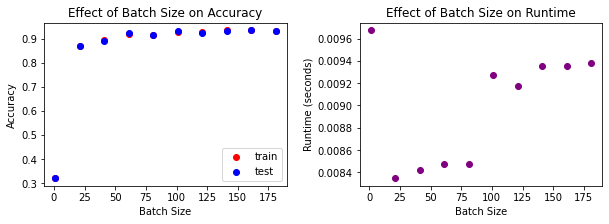

In [11]:
# Altering Batch Size
GridSearch(X=digitsX, y=digitsy, param="Batch Size", _lr=0.9, _beta=0.5)

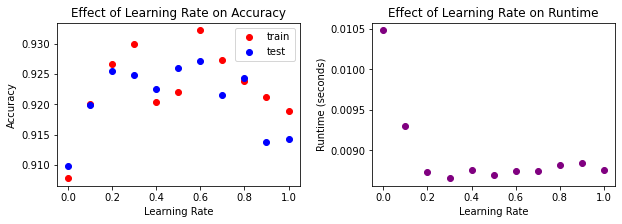

In [12]:
# Altering Learning Rate
GridSearch(X=digitsX, y=digitsy, param="Learning Rate", _bs=100, _beta=0.5)

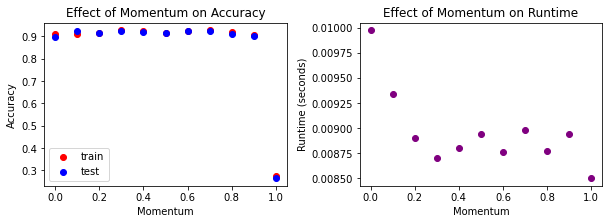

In [13]:
# Altering Momentum
GridSearch(X=digitsX, y=digitsy, param="Momentum", _bs=100, _lr=0.9)

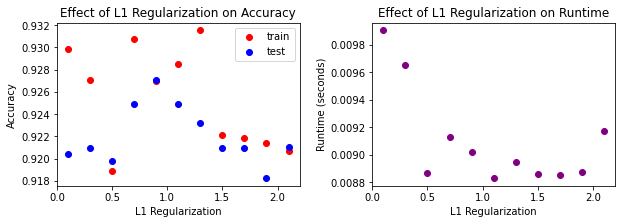

In [14]:
# Altering L1
GridSearch(X=digitsX, y=digitsy, param="L1 Regularization", _bs=100, _lr=0.9, _beta=0.5)

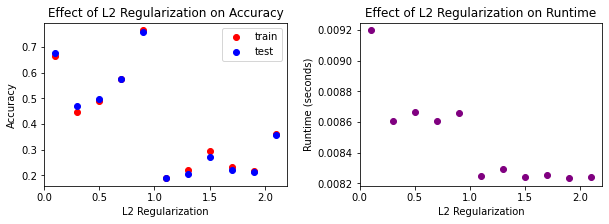

In [15]:
# Altering L2
GridSearch(X=digitsX, y=digitsy, param="L2 Regularization", _bs=100, _lr=0.9, _beta=0.5)

# Penguins

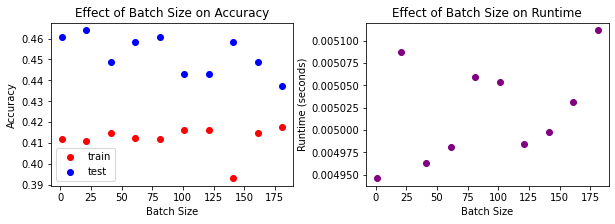

In [16]:
# Altering Batch Size
GridSearch(X=penguinsX, y=penguinsy, param="Batch Size", _lr=0.8, _beta=0.7)

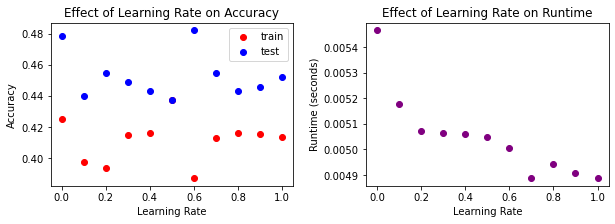

In [17]:
# Altering Learning Rate
GridSearch(X=penguinsX, y=penguinsy, param="Learning Rate", _bs=100, _beta=0.7)

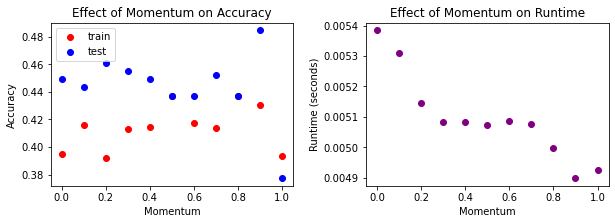

In [18]:
# Altering Momentum
GridSearch(X=penguinsX, y=penguinsy, param="Momentum", _bs=100, _lr=0.8)

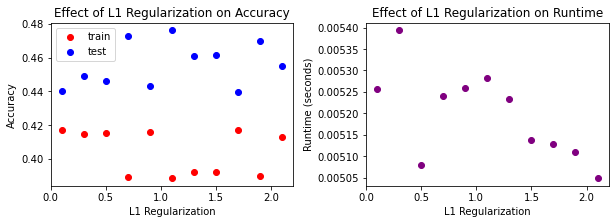

In [19]:
# Altering L1
GridSearch(X=penguinsX, y=penguinsy, param="L1 Regularization", _bs=100, _lr=0.8, _beta=0.7)

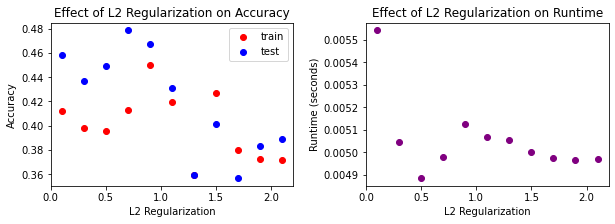

In [20]:
# Altering L2
GridSearch(X=penguinsX, y=penguinsy, param="L2 Regularization", _bs=100, _lr=0.8, _beta=0.7)

# DNA

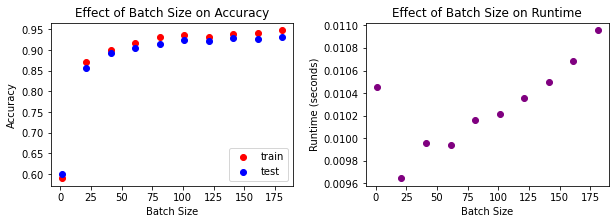

In [21]:
# Altering Batch Size
GridSearch(X=dnaX, y=dnay, param="Batch Size", _lr=0.8, _beta=0.4)

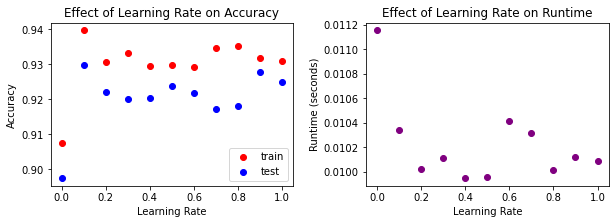

In [22]:
# Altering Learning Rate
GridSearch(X=dnaX, y=dnay, param="Learning Rate", _bs=100, _beta=0.4)

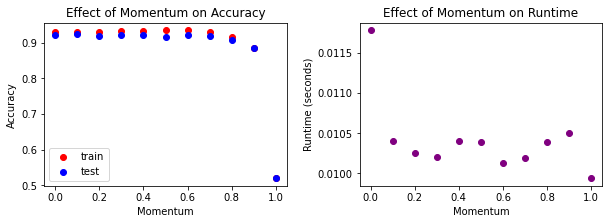

In [23]:
# Altering Momentum
GridSearch(X=dnaX, y=dnay, param="Momentum", _bs=100, _lr=0.8)

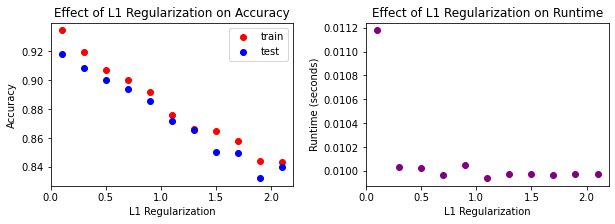

In [24]:
# Altering L1 Regularization
GridSearch(X=dnaX, y=dnay, param="L1 Regularization", _bs=100, _lr=0.8, _beta=0.4)

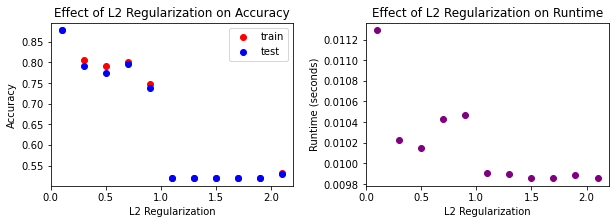

In [25]:
# Altering L2 Regularization
GridSearch(X=dnaX, y=dnay, param="L2 Regularization", _bs=100, _lr=0.8, _beta=0.4)

# Comparing Against Random Forest

In [28]:
def rand_forest(X, y):
    ns= range(1, 200, 10)
    train_scores = []
    test_scores = []
    runtimes = []
    indeces = [x for x in range(len(X))]
    shuffle(indeces)
    folds = [indeces[i:i + ceil(len(X) * 0.2)] for i in range(0, len(X), ceil(len(X) * 0.2))]
    for n in ns:
        rf = RandomForestClassifier(n_estimators=n)
        cur_train_scores = []
        cur_test_scores = []
        cur_times = []
        for i in range(5):
            train_indeces = []
            for j in range(4):
                train_indeces = train_indeces + folds[(i + j) % 5]
            test_indeces = folds[(i + 4) % 5]
            X_train, X_test, y_train, y_test = X[train_indeces], X[test_indeces], y[train_indeces], y[test_indeces] 
            
            start_time = time.time()
            rf.fit(X_train, y_train)
            runtime= time.time() - start_time
            
            cur_train_scores.append(rf.score(X_train, y_train))
            cur_test_scores.append(rf.score(X_test, y_test))
            cur_times.append(runtime)

        train_scores.append(np.average(np.array(cur_train_scores)))
        test_scores.append(np.average(np.array(cur_test_scores)))
        runtimes.append(np.average(np.array(cur_times)))
    #create subplots for graphs
    fig, axs = plt.subplots(ncols=2, figsize=(10,3))
    plt.subplots_adjust(wspace=0.3, hspace=0.5)
    for ax in axs.flat:
            ax.set_xlabel("Number of Trees", fontsize = 10)
        
    axs[0].set_title("Effect of # of Trees on Accuracy", fontsize = 12)
    axs[1].set_title("Effect of # of Tees on Runtime", fontsize = 12)
    train = axs[0].scatter(ns, train_scores, c='red', label="train")
    test = axs[0].scatter(ns, test_scores, c='blue', label="test")
    axs[0].set(ylabel="Accuracy")
    axs[0].legend(handles=[train,test])
    axs[1].scatter(ns, runtimes, c='purple')
    axs[1].set(ylabel="Runtime (seconds)")
    print ()       
    
    
#     plt.subplot(1,2,1)
#     train = plt.scatter(ns, train_scores, c='red', label="train")
#     test = plt.scatter(ns, test_scores, c='blue', label="test")
#     plt.legend(handles=[train,test])
#     plt.xlabel("Number of Trees")
#     plt.ylabel("Accuracy")
#     plt.title("Effect of # of Trees on Accuracy")
#     plt.tight_layout()

#     plt.subplot(1,2,2)
#     plt.scatter(ns, runtimes, c='purple')
#     plt.xlabel("Number of trees")
#     plt.ylabel("Runtime (seconds)")
#     plt.title("Effect of # of Tees on Runtime")
#     plt.tight_layout()

# Digits

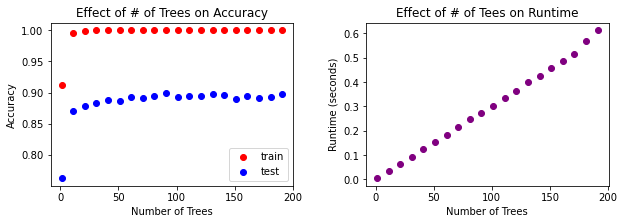

In [29]:
rand_forest(digitsX, digitsy)

# Penguins

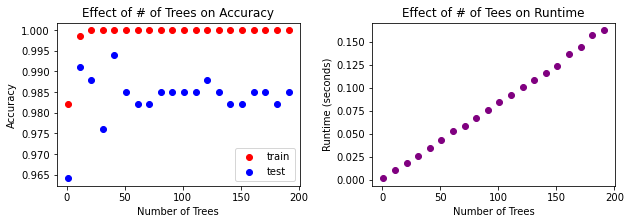

In [30]:
rand_forest(penguinsX, penguinsy)

# DNA

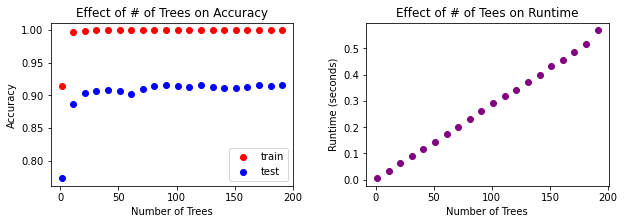

In [31]:
rand_forest(dnaX, dnay)